# Causal Transformer - iGPT

Objective
This project focuses on training an autoregressive (AR) model capable of handling multimodal
data, specifically text and image tokens. The model is designed to generate sequences in both
modalities, conditioned on either modality or unconditionally. For example, the model can
generate an image corresponding to the text prompt ”dark green eight on bright cyan” or,
conversely, produce descriptive text for a given image.

In [3]:
## Model definition

# TODOS
# Learning rate warmup and cos learning rate decay
# MHA

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import torch.optim.lr_scheduler as lr_scheduler
import math

# H : number of heads
# D : dimension of embeddings
# d : size of vocabulary i.e unique values of pixels

class SelfAttention(nn.Module):
    def __init__(self, D_in,D_out,drp_rate = 0.05):
        super().__init__()
        self.D_in = D_in
        self.D_out = D_out
        self.query_embed = nn.Linear(D_in, D_out)
        self.key_embed = nn.Linear(D_in, D_out)
        self.value_embed = nn.Linear(D_in, D_out)
        self.dropout = nn.Dropout(drp_rate)

    def forward(self, query_raw, key_raw, value_raw,attn_mask=None,need_weights=None): # q:(S,N,Ek), mask:(N,L,L)
        # compute q,k,v
        query = self.query_embed(query_raw.transpose(0,1))
        key = self.key_embed(key_raw.transpose(0,1))
        value = self.value_embed(value_raw.transpose(0,1))
        key_transposed = torch.transpose(key, 1, 2)
        # scale dot prod
        attention_weights = torch.matmul(query, key_transposed) / math.sqrt(self.D_out) # (n_query,n_key)
        # apply mask
        if attn_mask is not None:
            attention_weights = attention_weights + attn_mask
            # indices = torch.triu_indices(
            #     attention_weights.shape[1], attention_weights.shape[2], offset=1
            # )
            # attention_weights[:, indices[0], indices[1]] = float("-inf")
        attention_weights = F.softmax(attention_weights, dim=2)
        # weight values by attention
        attention_weighted_value = torch.matmul(
            attention_weights, value
        )
        attention_weighted_value = self.dropout(attention_weighted_value)
        return attention_weighted_value.transpose(0,1)

class MultiheadAttention(nn.Module):
    def __init__(self, D, H):
        assert D % H == 0, "embed_dim must be divisible by num_heads"
        super().__init__()
        self.attention_blocks = nn.ModuleList(
            [SelfAttention(D_in=D,D_out=D//H) for _ in range(H)]
        )

    def forward(self, query, key, value,attn_mask,need_weights):
        attention_out = torch.tensor([], requires_grad=True).cuda()
        for attention in self.attention_blocks:
            attention_out = torch.cat(
                (attention_out, attention(query, key, value,attn_mask)), dim=2
            )
        return attention_out,''

class TransformerBlock(nn.Module):
    def __init__(self, D, H):
        super().__init__()
        self.layernorm_1 = nn.LayerNorm(D)
        self.layernorm_2 = nn.LayerNorm(D)
        self.linear_1 = nn.Linear(D, D)
        self.linear_2 = nn.Linear(D, D)
        self.attention = MultiheadAttention(D, H)
        self.ff = nn.Sequential(
            nn.Linear(D, D*4), # expansion as proposed in paper
            nn.GELU(),
            nn.Linear(D*4, D),
        )
        self.mask = None

    def forward(self, x):
        self.mask = torch.full(
            (len(x), len(x)), -float("Inf"), device=x.device, dtype=x.dtype)
        self.mask = torch.triu(self.mask, diagonal=1)
        # layer norm
        x1 = self.layernorm_1(x)
        # linear tranform
        x1 = self.linear_1(x1)
        # multihead
        a, _ = self.attention(x1, x1, x1, attn_mask=self.mask, need_weights=False)
        # linear tranform
        a = self.linear_1(a)
        # residual and layer norm
        x = self.layernorm_2(x + a)
        # feed forward. TODO: make columnwise parallelizable
        m = self.ff(x)
        # residual
        x = x + m
        return x


class imageGPT(nn.Module):
  def __init__(
    self, D, H,
    n_layers, # 2
    n_pos,
    n_vocab # TODO: change to d
    ):
    super().__init__()
    self.D = D

    # beginning of sequence token
    self.bos = torch.nn.Parameter(torch.zeros(D), requires_grad=False)
    nn.init.normal_(self.bos)

    self.tok_embeddings = nn.Embedding(n_vocab, D)
    self.pos_embeddings = nn.Embedding(n_pos, D)

    self.layers = nn.ModuleList()
    for _ in range(n_layers):
        self.layers.append(TransformerBlock(D, H))

    self.layernorm_3 = nn.LayerNorm(D)
    self.head = nn.Linear(D, n_vocab, bias=False)

  def forward(self, x):
    """
    Input shape [batch, n_pos]
    """
    # prepare input
    x = x.transpose(0,1)
    x_length, batch = x.shape
    # embed tokens
    e = self.tok_embeddings(x)
    # input bos token
    bos = torch.ones(1, batch, self.D, device=x.device) * self.bos
    e = torch.cat([bos, e[:-1, :, :]], axis=0)
    # include positional embeddings
    pos = torch.arange(x_length, device=x.device).unsqueeze(-1)
    e = e + self.pos_embeddings(pos).expand_as(e)
    # transformer layers
    for layer in self.layers:
        e = layer(e)
    # layer normalize
    e = self.layernorm_3(e)
    # linear transform
    logits = self.head(e)
    logits = logits.permute(1,2,0) # check Permutation
    return logits

  def loss(self, x):
    return F.cross_entropy(self(x),x.long())

In [4]:
## Data Processing

def flatten_data(data,num_channels=1):
  flat_data = torch.from_numpy(data).long()
  return flat_data.squeeze(-1).view(flat_data.shape[0],-1,num_channels)

In [5]:
# imageGPT Training routine

clip = False
tocuda = True
def train_one_epoch(model, dloader, optimizer, epoch_num):

  # set to training mode
  model.train()

  epoch_losses = []

  for batch in dloader:
    #batch = batch[0]
    if tocuda == True:
      batch = batch.cuda()
    loss = model.loss(batch)
    optimizer.zero_grad() # zero out gradients before backward pass
    loss.backward()
    if clip:
      torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()
    epoch_losses.append(loss.item())
  return epoch_losses


def calc_loss(model, dloader):

  # set to evaluation mode
  model.eval()

  cumul_loss = 0.0
  n_samples = 0

  with torch.no_grad(): # disable gradient calcs for efficiency
    for batch in dloader:
      #batch = batch[0]
      if tocuda == True:
        batch = batch.cuda()
      loss = model.loss(batch)
      cumul_loss += loss.item() * len(batch)
      n_samples += len(batch)
      mean_loss = cumul_loss / n_samples
  return mean_loss


def train_model(model, train_dloader, test_dloader, training_params, show_progress = True):

  n_epochs, lr = training_params['n_epochs'], training_params['lr']
  optimizer = optim.Adam(model.parameters(), lr=lr)
  scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.99) # found to work appropriately enough

  train_losses = []
  test_losses = [calc_loss(model, test_dloader)]

  for epoch_num in range(n_epochs):
    # set to training mode
    model.train()

    epoch_losses_train = train_one_epoch(model, train_dloader, optimizer, epoch_num)
    train_losses.extend(epoch_losses_train)

    epoch_loss_test = calc_loss(model, test_dloader)
    test_losses.append(epoch_loss_test)
    scheduler.step()

    if show_progress:
      print(f"Epoch number: {epoch_num}, Loss on test data: {epoch_loss_test} ")

  return train_losses, test_losses


def sample(model,input_shape,n_samples=1):
  n_pos = np.prod(input_shape)
  if tocuda == True:
      samples = torch.zeros(n_samples, n_pos).long().cuda()
  else:
      samples = torch.zeros(n_samples, n_pos).long()
  with torch.no_grad():
    for i in range(n_pos):
      logits = model(samples)[:,:,i]
      probas = F.softmax(logits, dim=1)
      samples[:,i] = torch.multinomial(probas, num_samples=1).squeeze(-1)
    samples = samples.view(n_samples, *input_shape)
  samples = torch.unsqueeze(samples,-1)
  return samples.cpu().numpy() * 255

In [ ]:
batch_size=64
_,h,w,channels = train_data.shape

# flatten data
train_data_flt = torch.from_numpy(train_data).long()
train_data_flt = train_data_flt.squeeze(-1).view(train_data_flt.shape[0],-1)
test_data_flt = torch.from_numpy(test_data).long()
test_data_flt = test_data_flt.squeeze(-1).view(test_data_flt.shape[0],-1)

if tocuda == True:
  model = imageGPT(D=128,
            H=4,
            n_layers=2, # 2
            n_pos=h*w,
            n_vocab=2
  ).cuda()
else:
  model = imageGPT(D=128,
            H=4,
            n_layers=2, # 2
            n_pos=h*w,
            n_vocab=2
  )
train_loader = data.DataLoader(train_data_flt, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_data_flt, batch_size=batch_size)
train_losses, test_losses = train_model(model, train_loader, test_loader,
                                          dict(n_epochs=15, lr=1e-3))
samples = sample(model,(h,w),n_samples=100)

iGPT on Colored Shapes and MNIST

Now we implement an iGPT that models color.


In [6]:
# Data preprocessing

def tokenize_images(flat_data,num_channels=3):
  mapping = torch.tensor([[1],[4],[16]],dtype=flat_data[0].dtype)
  mapping = mapping.repeat(flat_data.shape[0],1).view(flat_data.shape[0],num_channels,1)
  return torch.matmul(flat_data,mapping).squeeze(-1)

def reverse_tokenization(tokens):
    tokens = tokens/255
    tokens = torch.tensor(tokens,dtype=torch.int64) # ensure int

    r = tokens // (4**1) % 4
    g = tokens // (4**0) % 4
    b = tokens // (4**2) % 4

    rgb_values = torch.stack((r, g, b), dim=-1)
    rgb_values = rgb_values.numpy()
    rgb_values = rgb_values[:,:,:,0]
    rgb_values = rgb_values[...,[1,0,2]]

    return rgb_values



In [ ]:

batch_size=32
_,h,w,channels = train_data.shape

# flatten data
train_data_flt = flatten_data(train_data,num_channels=channels)
test_data_flt = flatten_data(test_data,num_channels=channels)

# tokenize imgs
train_data_flt = tokenize_images(train_data_flt)
test_data_flt = tokenize_images(test_data_flt)
# train model
if tocuda == True:
  model = imageGPT(D=128, # using built in MHA for performance
            H=4,
            n_layers=2, # 2
            n_pos=h*w,
            n_vocab=64
  ).cuda()
else:
  model = imageGPT(D=128,
            H=4,
            n_layers=2, # 2
            n_pos=h*w,
            n_vocab=64
  )


train_loader = data.DataLoader(train_data_flt, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_data_flt, batch_size=batch_size)
train_losses, test_losses = train_model(model, train_loader, test_loader,
                                          dict(n_epochs=15, lr=1e-3))
# samples
samples = sample(model,input_shape=(h,w),n_samples=100)
# reverse tokenize imgs

samples = reverse_tokenization(samples)

Autoregressive Transformer on Colored Shapes and MNIST with Vector Quantization

We can use the VQVAE to tokenize an image dataset. This will result in a much smaller sequence length.

In [ ]:
# Data Processing

from tqdm import tqdm

def batch_quantize(data,quantize, batch_size=600):
    num_batches = data.shape[0]// batch_size
    quantized_data = torch.zeros(data.shape[0],7,7)
    for i in tqdm(range(num_batches)):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, data.shape[0])
        batch_data = data[start_idx:end_idx]
        quantized_batch = quantize(batch_data)
        quantized_data[start_idx:end_idx] = quantized_batch
        del quantized_batch
    return quantized_data

In [ ]:
batch_size=32

# tokenize images in batches
with torch.no_grad():
  train_data = batch_quantize(train_data,vqvae.quantize)
  test_data = batch_quantize(test_data,vqvae.quantize)
N,h,w = train_data.shape

# flatten data
train_data_flt = flatten_data(train_data.numpy(),num_channels=1).squeeze(-1)
test_data_flt = flatten_data(test_data.numpy(),num_channels=1).squeeze(-1)

# train model
if tocuda == True:
  model = imageGPT(D=128,  # using built in MHA for performance
            H=4,
            n_layers=4,
            n_pos=h*w,
            n_vocab=vqvae.n_embeddings
  ).cuda()
else:
  model = imageGPT(D=128,
            H=4,
            n_layers=4,
            n_pos=h*w,
            n_vocab=vqvae.n_embeddings
  )

train_loader = data.DataLoader(train_data_flt, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_data_flt, batch_size=batch_size)
train_losses, test_losses = train_model(model, train_loader, test_loader,
                                          dict(n_epochs=30, lr=1e-3))
# produce samples
samples = sample(model,input_shape=(h,w),n_samples=100).squeeze(-1)
# reverse tokenize imgs
samples = vqvae.decode(samples/255)

# Causal Transformer: Text

Now lets consider text! (LLMs).
We will now implement a simplified version.

We will be detailing with a [small poetry dataset](https://huggingface.co/datasets/merve/poetry). See some of the data below.

Sample 1
Who will in fairest book of nature know
How virtue may best lodg'd in beauty be,
Let him but learn of love to read in thee,
Stella, those fair lines which true goodness show.
There shall he find all vices' overthrow,
Not by rude force, but sweetest sovereignty
Of reason, from whose light those night-birds fly;
That inward sun in thine eyes shineth so.
And, not content to be perfection's heir
Thyself, dost strive all minds that way to move,
Who mark in thee what is in thee most fair.
So while thy beauty draws thy heart to love,
As fast thy virtue bends that love to good:
But "Ah," Desire still cries, "Give me some food!"
--------------------------------------------------------------------------------

Sample 2
What length of verse can serve brave Mopsas good to show,
Whose virtues strange, and beauties such, as no man them may know?
Thus shrewdly burden, then, how can my Muse escape?
The gods must help, and precious things must serve to show her shape.

Like great god Saturn, f

Modeling Text
We train a transformer on the poetry dataset.

In [ ]:
## DATA PREPROCESSING

from random import shuffle
from os.path import join

# Helper functions

def build_vocab(texts):
    # Expects texts to be list of strings
    vocab = {'<pad>': 0, '<bos>': 1, '<eos>': 2}
    for text in texts:
        for char in text:
            if char not in vocab:
                vocab[char] = len(vocab)
    return vocab

def tokenize_texts(texts, vocab):
    tokenized_texts = []
    for text in texts:
        tokenized_text = [vocab['<bos>']] + [vocab[char] for char in text] + [vocab['<eos>']]
        tokenized_texts.append(tokenized_text)
    return tokenized_texts # Outputs List of lists with sequences (poems) with bos & eos attached

def create_subsequences(tokenized_texts, subseq_length=128, pad_token=0):
    all_subsequences = []
    for seq in tokenized_texts:
        subsequences = []
        for i in range(0, len(seq), subseq_length):
            subseq = seq[i:i+subseq_length]
            if len(subseq) < subseq_length:
                subseq += [pad_token] * (subseq_length - len(subseq))
            subsequences.append(subseq)
        all_subsequences.append(subsequences)
    return all_subsequences # Outputs List of lists (poems) of lists (128 long subsequences)

def flatten_subsequences(blocks):
    return [subseq for block in blocks for subseq in block]

def shuffle_subsequences(blocks, blockwise=False):
    if blockwise == True:
        for block in blocks:
            shuffle(block)
    else:
        blocks = [flatten_subsequences(blocks)]
        for block in blocks:
            shuffle(block)
    return blocks

def token_to_text(samples_tok, inverse_vocab):
    samples_tok = list(samples_tok)
    samples_text = [''.join([inverse_vocab[id] for id in sample]) for sample in samples_tok]

    return samples_text

In [ ]:
## Model definition

import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

# TODOs
# delete BOS from Model
# implement Mask for padding tokens in attention layers

class TransformerBlock(nn.Module):
    def __init__(self, D, H):
        super().__init__()
        self.layernorm_1 = nn.LayerNorm(D)
        self.layernorm_2 = nn.LayerNorm(D)
        self.linear_1 = nn.Linear(D, D)
        self.linear_2 = nn.Linear(D, D)
        self.attention = nn.MultiheadAttention(D, H) # use nn.MHA to implement padding mask
        self.ff = nn.Sequential(
            nn.Linear(D, D*4), # expansion as proposed in paper
            nn.GELU(),
            nn.Linear(D*4, D),
        )
        self.mask = None

    def forward(self, x, pad_mask=None):
        seq_length, batch_size, _ = x.size()
        self.mask = torch.full(
            (len(x), len(x)), -float("Inf"), device=x.device, dtype=x.dtype)
        self.mask = torch.triu(self.mask, diagonal=1)
        # layer norm
        x1 = self.layernorm_1(x)
        # linear tranform
        x1 = self.linear_1(x1)
        # multihead
        a, _ = self.attention(x1, x1, x1, attn_mask=self.mask, key_padding_mask=pad_mask, need_weights=False) # Pad mask shape (batch_size, sequence_length), True = 1 = IGNORED = Padding
        # linear tranform
        a = self.linear_1(a)
        # residual and layer norm
        x = self.layernorm_2(x + a)
        # feed forward. TODO: make columnwise parallelizable
        m = self.ff(x)
        # residual
        x = x + m
        return x

class textGPT(nn.Module):
  def __init__(
    self, D, H,
    n_layers, # 4
    n_pos,
    n_vocab
    ):
    super().__init__()
    self.D = D

    # # beginning of sequence token (inclusion lead to much better. performance)
    # self.bos = torch.nn.Parameter(torch.zeros(D), requires_grad = False) #deletion from model leads to lower performance
    # nn.init.normal_(self.bos) #deletion from model leads to lower performance

    self.tok_embeddings = nn.Embedding(n_vocab, D)
    self.pos_embeddings = nn.Embedding(n_pos, D)

    self.layers = nn.ModuleList()
    for _ in range(n_layers):
        self.layers.append(TransformerBlock(D, H))

    self.layernorm_3 = nn.LayerNorm(D)
    self.head = nn.Linear(D, n_vocab, bias=False)

  def forward(self, x):
    """
    Input shape [batch, n_pos]
    """
    # prepare input
    x = x.transpose(0,1)
    x_length, batch = x.shape
    # embed tokens
    e = self.tok_embeddings(x) #shape (subsequence_length, batch_size, embed_dim)

    # bos = torch.ones(1, batch, self.D, device=x.device) * self.bos
    # e = torch.cat([bos, e[:-1, :, :]], axis=0)

    pad_mask = (x == 0).transpose(0,1) #shape (batch_size, subsequence_length)

    # include positional embeddings
    pos = torch.arange(x_length, device=x.device).unsqueeze(-1)
    e = e + self.pos_embeddings(pos).expand_as(e)
    # transformer layers
    for layer in self.layers:
        e = layer(e, pad_mask = pad_mask)
    # layer normalize
    e = self.layernorm_3(e)
    # linear transform
    logits = self.head(e)
    logits = logits.permute(1,2,0) # check Permutation
    return logits

  def loss(self, x):
    input = self(x) # shape (batch_size, vocab_length (logits), sequence_length)
    target = x.long() # shape (batch_size, sequence_length)

    # shift (required if bos prepending disabled)
    input = input[:,:,:-1]
    target = target[:,1:]

    return F.cross_entropy(input, target)


In [ ]:
# textGPT Training routine

clip = True
tocuda = True

def train_one_epoch(model, dloader, optimizer, epoch_num):

  # set to training mode
  model.train()

  epoch_losses = []

  for batch in dloader:
    batch = batch[0] # shape (batch_size, subsequence_length), dtype = tensor
    if tocuda == True:
      batch = batch.cuda()
    loss = model.loss(batch)
    optimizer.zero_grad() # zero out gradients before backward pass
    loss.backward()
    if clip:
      torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()
    epoch_losses.append(loss.item())
  return epoch_losses


def calc_loss(model, dloader):

  # set to evaluation mode
  model.eval()

  cumul_loss = 0.0
  n_samples = 0

  with torch.no_grad(): # disable gradient calcs for efficiency
    for batch in dloader:
        batch = batch[0] # shape (batch_size, subsequence_length), dtype = tensor
        if tocuda == True:
          batch = batch.cuda()
        loss = model.loss(batch)
        cumul_loss += loss.item() * len(batch)
        n_samples += len(batch)
    mean_loss = cumul_loss / n_samples
  return mean_loss


def train_model(model, train_tok_ss, test_tok_ss, batch_size, training_params, show_progress = True):
  # expects for train_dloader: List of poem lists (blocks) containing lists of subsequences with fixed length
  n_epochs, lr = training_params['n_epochs'], training_params['lr']
  optimizer = optim.Adam(model.parameters(), lr=lr)

  ss_test_flt = flatten_subsequences(test_tok_ss) # list of lists with subsequences of fixed length (no poem relationship)
  ss_test_flt = torch.tensor(ss_test_flt, dtype=torch.long)
  ss_test_flt = TensorDataset(ss_test_flt)
  test_dloader = data.DataLoader(ss_test_flt, batch_size=batch_size)

  train_losses = []
  test_losses = [calc_loss(model, test_dloader)]

  for epoch_num in range(n_epochs):
    # set to training mode
    model.train()

    # shuffle subsequences (across all poems)
    train_ss_shuffled = shuffle_subsequences(train_tok_ss, blockwise = False) # List of List of all shuffeled subsequences
    ss_train_flt = flatten_subsequences(train_ss_shuffled) # List of all shuffled subsequences
    ss_train_flt = torch.tensor(ss_train_flt, dtype=torch.long)
    ss_train_flt = TensorDataset(ss_train_flt)
    train_dloader =  data.DataLoader(ss_train_flt, batch_size=batch_size, shuffle=False)

    epoch_losses_train = train_one_epoch(model, train_dloader, optimizer, epoch_num)
    train_losses.extend(epoch_losses_train)

    epoch_loss_test = calc_loss(model, test_dloader)
    test_losses.append(epoch_loss_test)

    if show_progress:
      print(f"Epoch number: {epoch_num}, Loss on test data: {epoch_loss_test} ")

  return train_losses, test_losses

In [ ]:
# Sampling
def sample(model, sample_length, bos=1, num_samples=2):
  samples = torch.zeros(num_samples, sample_length).long().cuda()
  samples[:, 0] = bos
  with torch.no_grad():
    for i in range(sample_length):
      logits = model(samples)[:,:,i]
      probas = F.softmax(logits, dim=1)
      if i < (sample_length-1):
        samples[:,i+1] = torch.multinomial(probas, num_samples=1).squeeze(1)
  return samples.cpu().numpy()

In [ ]:
batch_size=64
subsequence_length = 128

# preprocess data
vocab = build_vocab(train_text)
n_vocab = len(vocab)
train_data_tok = create_subsequences(tokenize_texts(train_text, vocab))
test_data_tok = create_subsequences(tokenize_texts(test_text, vocab))

model = textGPT(D=256,
          H=4,
          n_layers=3,
          n_pos=subsequence_length,
          n_vocab=n_vocab
).cuda()

train_losses, test_losses = train_model(model, train_data_tok, test_data_tok, batch_size,
                                          dict(n_epochs=10, lr=1e-3))
text_samples = sample(model, subsequence_length, num_samples=5)
#print(text_samples)
inverse_vocab = {v: k for k, v in vocab.items()}
text_samples = np.array(token_to_text(text_samples, inverse_vocab))

for i in range(len(text_samples)):
  text_samples[i] = np.char.replace(text_samples[i], '<pad>', '')
  text_samples[i] = np.char.replace(text_samples[i], '<bos>', '')



# Causal Transformer: Multimodal

So far, we have been dealing only with autoregressive generation of a single modality. Now we will train a model that operates on multiple modalities!

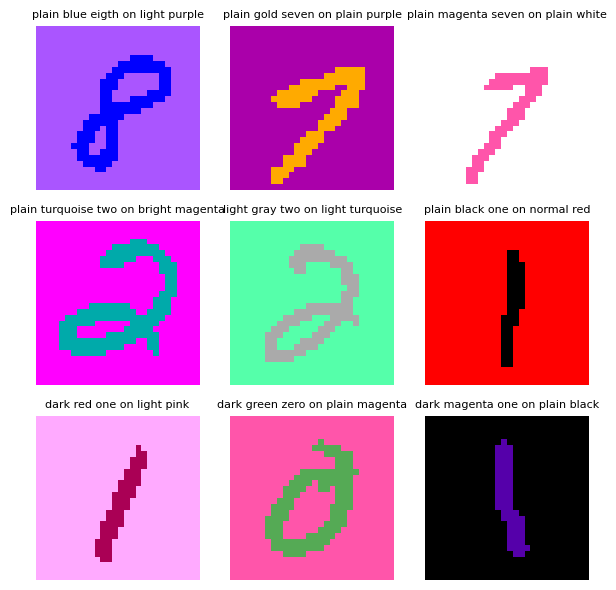

In [ ]:
# Data processing
from deepul.hw1_helper import load_pretrain_vqvae
vqvae = load_pretrain_vqvae("colored_mnist_2")

def create_vocab(text_list, eot=1026, eoi=1025):
    all_words = ' '.join(text_list).split()
    unique_words = sorted(set(all_words))
    vocab = {word: i+eot for i, word in enumerate(unique_words)}
    vocab['<eot>'] = eot
    vocab['<eoi>'] = eoi
    return vocab

def tokenize_text(text_list, vocab):
    tokenized_texts = []
    for text in text_list:
        tokens = [vocab[word] for word in text.split()] + [vocab['<eot>']]
        tokenized_texts.append(tokens)
    tokenized_texts = np.array(tokenized_texts, dtype=float)
    return torch.from_numpy(tokenized_texts)

from tqdm import tqdm

def batch_quantize(data,quantize, batch_size=3000):
    num_batches = data.shape[0]// batch_size
    quantized_data = torch.zeros(data.shape[0],7,7)
    for i in tqdm(range(num_batches)):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, data.shape[0])
        batch_data = data[start_idx:end_idx]
        quantized_batch = quantize(batch_data)
        quantized_data[start_idx:end_idx] = quantized_batch
        del quantized_batch
    return quantized_data

def flatten_data(data, num_channels=1):
  return data.squeeze(-1).view(data.shape[0],-1,num_channels).squeeze(2)

def add_eoi_token(tokenized_images_flt, eoi=1025):
    eoi_tokens = torch.full((tokenized_images_flt.size(0), 1), eoi, dtype=tokenized_images_flt.dtype)
    return torch.cat((tokenized_images_flt, eoi_tokens), dim=1)

def token_to_text(samples_tok, inverse_vocab):
    samples_text = [' '.join([inverse_vocab[id] for id in sample]) for sample in samples_tok]
    return samples_text

def create_dataset(images_tok_flt, text_tok_flt):
    mid = int(images_tok_flt.shape[0]/2)
    up_half = torch.cat((images_tok_flt[:mid,-1].unsqueeze(0).transpose(0,1), text_tok_flt[:mid,:], images_tok_flt[:mid,:-1]), dim=1)
    low_half = torch.cat((text_tok_flt[mid:,-1].unsqueeze(0).transpose(0,1), images_tok_flt[mid:,:], text_tok_flt[mid:,:-1]), dim=1)
    return torch.cat((up_half, low_half))

def create_dataset_ordered(images_tok_flt, text_tok_flt):
    dataset = torch.cat((images_tok_flt[:,-1].unsqueeze(0).transpose(0,1), text_tok_flt[:,:], images_tok_flt[:,:-1]), dim=1)
    return dataset

# Create training/test data:

def create_inputs(labels, data):
    vocab_text = create_vocab(labels)
    text_tok_flt = tokenize_text(labels, vocab_text)
    images_tok = batch_quantize(data, vqvae.quantize)
    images_tok_flt = add_eoi_token(flatten_data(images_tok))
    #return create_dataset_ordered(images_tok_flt, text_tok_flt).long()
    return create_dataset(images_tok_flt, text_tok_flt).long()


In [ ]:
def get_text(sample, final_state, inverse_vocab, text_length=6):
  if final_state == "text":
    tok_text = sample[-text_length:]
  else:
    tok_text = sample[1:(text_length+1)]

  detok_text = token_to_text([tok_text], inverse_vocab)
  return detok_text

def get_image(sample, final_state, image_length=49):
  if final_state == "image":
    tok_image = np.expand_dims(sample[-image_length:].reshape(7,7), axis=0)
  else:
    tok_image = np.expand_dims(sample[1:(image_length+1)].reshape(7,7), axis=0)
  detok_image = vqvae.decode(tok_image) #*255?
  return detok_image

In [ ]:
## Model definition

# TODOS
# Learning rate warmup and cos learning rate decay
# MHA

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import torch.optim.lr_scheduler as lr_scheduler
import math

# H : number of heads
# D : dimension of embeddings
# d : size of vocabulary i.e unique values of pixels

class SelfAttention(nn.Module):
    def __init__(self, D_in,D_out,drp_rate = 0.05):
        super().__init__()
        self.D_in = D_in
        self.D_out = D_out
        self.query_embed = nn.Linear(D_in, D_out)
        self.key_embed = nn.Linear(D_in, D_out)
        self.value_embed = nn.Linear(D_in, D_out)
        self.dropout = nn.Dropout(drp_rate)

    def forward(self, query_raw, key_raw, value_raw,attn_mask=None,need_weights=None): # q:(S,N,Ek), mask:(N,L,L)
        # compute q,k,v
        query = self.query_embed(query_raw.transpose(0,1))
        key = self.key_embed(key_raw.transpose(0,1))
        value = self.value_embed(value_raw.transpose(0,1))
        key_transposed = torch.transpose(key, 1, 2)
        # scale dot prod
        attention_weights = torch.matmul(query, key_transposed) / math.sqrt(self.D_out) # (n_query,n_key)
        # apply mask
        if attn_mask is not None:
            attention_weights = attention_weights + attn_mask
            # indices = torch.triu_indices(
            #     attention_weights.shape[1], attention_weights.shape[2], offset=1
            # )
            # attention_weights[:, indices[0], indices[1]] = float("-inf")
        attention_weights = F.softmax(attention_weights, dim=2)
        # weight values by attention
        attention_weighted_value = torch.matmul(
            attention_weights, value
        )
        attention_weighted_value = self.dropout(attention_weighted_value)
        return attention_weighted_value.transpose(0,1)

class MultiheadAttention(nn.Module):
    def __init__(self, D, H):
        assert D % H == 0, "embed_dim must be divisible by num_heads"
        super().__init__()
        self.attention_blocks = nn.ModuleList(
            [SelfAttention(D_in=D,D_out=D//H) for _ in range(H)]
        )

    def forward(self, query, key, value,attn_mask,need_weights):
        attention_out = torch.tensor([], requires_grad=True).cuda()
        for attention in self.attention_blocks:
            attention_out = torch.cat(
                (attention_out, attention(query, key, value,attn_mask)), dim=2
            )
        return attention_out,''

class TransformerBlock(nn.Module):
    def __init__(self, D, H):
        super().__init__()
        self.layernorm_1 = nn.LayerNorm(D)
        self.layernorm_2 = nn.LayerNorm(D)
        self.linear_1 = nn.Linear(D, D)
        self.linear_2 = nn.Linear(D, D)
        self.attention = MultiheadAttention(D, H)
        self.ff = nn.Sequential(
            nn.Linear(D, D*4), # expansion as proposed in paper
            nn.GELU(),
            nn.Linear(D*4, D),
        )
        self.mask = None

    def forward(self, x):
        self.mask = torch.full(
            (len(x), len(x)), -float("Inf"), device=x.device, dtype=x.dtype)
        self.mask = torch.triu(self.mask, diagonal=1)
        # layer norm
        x1 = self.layernorm_1(x)
        # linear tranform
        x1 = self.linear_1(x1)
        # multihead
        a, _ = self.attention(x1, x1, x1, attn_mask=self.mask, need_weights=False)
        # linear tranform
        a = self.linear_1(a)
        # residual and layer norm
        x = self.layernorm_2(x + a)
        # feed forward. TODO: make columnwise parallelizable
        m = self.ff(x)
        # residual
        x = x + m
        return x


class imageGPT(nn.Module):
  def __init__(
    self, D, H,
    n_layers, # 2
    n_pos,
    n_vocab # TODO: change to d
    ):
    super().__init__()
    self.D = D

    # beginning of sequence token
    #self.bos = torch.nn.Parameter(torch.zeros(D), requires_grad=False)
    #nn.init.normal_(self.bos)

    self.tok_embeddings = nn.Embedding(n_vocab, D)
    self.pos_embeddings = nn.Embedding(n_pos, D)

    self.layers = nn.ModuleList()
    for _ in range(n_layers):
        self.layers.append(TransformerBlock(D, H))

    self.layernorm_3 = nn.LayerNorm(D)
    self.head = nn.Linear(D, n_vocab, bias=False)

  def forward(self, x):
    """
    Input shape [batch, n_pos]
    """
    # prepare input
    x = x.transpose(0,1)
    x_length, batch = x.shape
    # embed tokens
    e = self.tok_embeddings(x)
    # input bos token
    # bos = torch.ones(1, batch, self.D, device=x.device) * self.bos
    # e = torch.cat([bos, e[:-1, :, :]], axis=0)
    # include positional embeddings
    pos = torch.arange(x_length, device=x.device).unsqueeze(-1)
    e = e + self.pos_embeddings(pos).expand_as(e)
    # transformer layers
    for layer in self.layers:
        e = layer(e)
    # layer normalize
    e = self.layernorm_3(e)
    # linear transform
    logits = self.head(e)
    logits = logits.permute(1,2,0) # check Permutation
    return logits

  def loss(self, x):

    input = self(x) # shape (batch_size, vocab_length (logits), sequence_length)
    target = x.long() # shape (batch_size, sequence_length)

    # shift (required if bos prepending disabled)
    input = input[:,:,:-1]
    target = target[:,1:]
    return F.cross_entropy(input,target)

In [ ]:
# imageGPT Training routine

clip = False
tocuda = True
def train_one_epoch(model, dloader, optimizer, epoch_num):

  # set to training mode
  model.train()

  epoch_losses = []

  for batch in dloader:
    #batch = batch[0]
    if tocuda == True:
      batch = batch.cuda()
    loss = model.loss(batch)
    optimizer.zero_grad() # zero out gradients before backward pass
    loss.backward()
    if clip:
      torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()
    epoch_losses.append(loss.item())
  return epoch_losses


def calc_loss(model, dloader):

  # set to evaluation mode
  model.eval()

  cumul_loss = 0.0
  n_samples = 0

  with torch.no_grad(): # disable gradient calcs for efficiency
    for batch in dloader:
      #batch = batch[0]
      if tocuda == True:
        batch = batch.cuda()
      loss = model.loss(batch)
      cumul_loss += loss.item() * len(batch)
      n_samples += len(batch)
      mean_loss = cumul_loss / n_samples
  return mean_loss


def train_model(model, train_dloader, test_dloader, training_params, show_progress = True):

  n_epochs, lr = training_params['n_epochs'], training_params['lr']
  optimizer = optim.Adam(model.parameters(), lr=lr)
  scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.99) # found to work appropriately enough

  train_losses = []
  test_losses = [calc_loss(model, test_dloader)]

  for epoch_num in range(n_epochs):
    # set to training mode
    model.train()

    epoch_losses_train = train_one_epoch(model, train_dloader, optimizer, epoch_num)
    train_losses.extend(epoch_losses_train)

    epoch_loss_test = calc_loss(model, test_dloader)
    test_losses.append(epoch_loss_test)
    scheduler.step()

    if show_progress:
      print(f"Epoch number: {epoch_num}, Loss on test data: {epoch_loss_test} ")

  return train_losses, test_losses


# def sample(model,input_shape,n_samples=1):
#   n_pos = np.prod(input_shape)
#   if tocuda == True:
#       samples = torch.zeros(n_samples, n_pos).long().cuda()
#   else:
#       samples = torch.zeros(n_samples, n_pos).long()
#   with torch.no_grad():
#     for i in range(n_pos):
#       logits = model(samples)[:,:,i]
#       probas = F.softmax(logits, dim=1)
#       samples[:,i] = torch.multinomial(probas, num_samples=1).squeeze(-1)
#     samples = samples.view(n_samples, *input_shape)
#   samples = torch.unsqueeze(samples,-1)
#   return samples.cpu().numpy() * 255

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import random

def sample_mm(model, total_vocab_length, text_length = 7, image_length = 50, context=-1, eoi=1025, eot=1026, num_samples=1):
    seq_length = text_length + image_length

    if type(context) == int:
        if context == -1:
            context = [random.choice([eoi, eot])]

    context_length = len(context)
    if context_length >= seq_length:
        raise ValueError("Context too long for the specified sequence length")
    elif (context_length != 8) and (context_length != 51) and (context_length != 1) :
        raise ValueError("Context not and image or text")

    # Define state
    if context[0] == eoi:
        if context_length == 1:
          state = 'text'
        else:
          state = 'image'
    elif context[0] == eot:
        if context_length == 1:
          state = 'image'
        else:
          state = 'text'
    else:
        raise ValueError("first element of context must be eoi or eot or pass -1 for unconditional sample")


    # Initialize samples tensor
    samples = torch.zeros(num_samples, seq_length).long().cuda()

    context_tensor = torch.tensor(context * num_samples).view(num_samples, -1).long().cuda()
    samples[:, :context_length] = context_tensor

    # Define blockers
    image_blocker = torch.cat([-torch.inf * torch.ones(eoi+2), torch.zeros(total_vocab_length - eoi-2)]).cuda()
    text_blocker = torch.cat([torch.zeros(eoi), -torch.inf * torch.ones(total_vocab_length - eoi)]).cuda()

    # Determine the number of tokens to generate based on the initial state
    if state == 'text':
        tokens_to_generate = text_length
    else:  # state == 'image'
        tokens_to_generate = image_length

    with torch.no_grad():
        for i in range(context_length, context_length+tokens_to_generate-1):
            logits = model(samples)[:, :, i-1]

            # block logits
            if state == 'image':
                logits += text_blocker
            elif state == 'text':
                logits += image_blocker

            probas = F.softmax(logits, dim=1)
            samples[:, i] = torch.multinomial(probas, num_samples=1).squeeze(1)

        if context_length == 1:

            idx_cont = int(sum(samples[0, :] != 0))

            # switch state and sample rest
            if state == 'text':
                state = 'image'
                samples[:, idx_cont] = eot
                tokens_to_generate = image_length
            else:  # state == 'image'
                state = 'text'
                samples[:, idx_cont] = eoi
                tokens_to_generate = text_length

            for i in range(idx_cont+1, tokens_to_generate+idx_cont):
                logits = model(samples)[:, :, i-1]

                # block logits
                if state == 'image':
                    logits += text_blocker
                elif state == 'text':
                    logits += image_blocker

                probas = F.softmax(logits, dim=1)
                samples[:, i] = torch.multinomial(probas, num_samples=1).squeeze(1)

    return samples.cpu().numpy(), state

In [ ]:
from deepul.helper import load_pretrain_vqvae
vqvae = load_pretrain_vqvae("colored_mnist_2")
import torch.utils.data as data

# Prepare prompts
vocab = create_vocab(train_text)
eoi = vocab['<eoi>']
eot = vocab['<eot>']
text_test_prompt = tokenize_text(text_test_prompt, vocab)
eoi_tokens = torch.full((text_test_prompt.shape[0], 1), eoi, dtype=text_test_prompt.dtype)
text_test_prompt = torch.cat((eoi_tokens, text_test_prompt), dim=1).long()

image_test_prompt = batch_quantize(image_test_prompt, vqvae.quantize, batch_size = 9)
image_test_prompt = add_eoi_token(flatten_data(image_test_prompt))
eot_tokens = torch.full((text_test_prompt.shape[0], 1), eot, dtype=text_test_prompt.dtype)
image_test_prompt = torch.cat((eot_tokens, image_test_prompt), dim=1).long()

# Model defintion
batch_size = 64
total_voc_length = 1024 + len(vocab)
multimodel = imageGPT(D=128,
            H=4,
            n_layers=4, # 2
            n_pos=57,
            n_vocab=total_voc_length).cuda()

# Training
# dataset_train = create_inputs(train_text[:3000], train_data[:3000, :, :, :])
# dataset_test = create_inputs(test_text[:3000], test_data[:3000, :, :, :])
dataset_train = create_inputs(train_text, train_data)
dataset_test = create_inputs(test_text, test_data)

train_loader = data.DataLoader(dataset_train.long(), batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset_test.long(), batch_size=batch_size)

train_losses, test_losses = train_model(multimodel, train_loader, test_loader,
                                          dict(n_epochs=30, lr=1e-3))


# Sampling
n_samples = 9
inverse_vocab = {v: k for k, v in vocab.items()}

# unconditional
samples_unconditioned = []
for s in range(n_samples):
  sample, state = sample_mm(multimodel, total_voc_length)
  sample = sample[0]
  image, text = get_image(sample, state), get_text(sample, state, inverse_vocab)
  samples_unconditioned.append((image[0], text[0]))

# text conditioned
samples_text_conditioned = []
for s in range(n_samples):
  sample, state = sample_mm(multimodel, total_voc_length, context = text_test_prompt[s])
  sample = sample[0]
  image, text = get_image(sample, state), get_text(sample, state, inverse_vocab)
  samples_text_conditioned.append((image[0], text[0]))

# image conditioned
samples_image_conditioned = []
for s in range(n_samples):
  sample, state = sample_mm(multimodel, total_voc_length, context = image_test_prompt[s])
  sample = sample[0]
  image, text = get_image(sample, state), get_text(sample, state, inverse_vocab)
  samples_image_conditioned.append((image[0], text[0]))

100%|██████████| 3/3 [00:23<00:00,  7.99s/it]


Epoch number: 0, Loss on test data: 3.259896866607666 
Epoch number: 1, Loss on test data: 2.981220974349976 
Epoch number: 2, Loss on test data: 2.916798168563843 
Epoch number: 3, Loss on test data: 2.817105918121338 
Epoch number: 4, Loss on test data: 2.734403405380249 
Epoch number: 5, Loss on test data: 2.685913344192505 
Epoch number: 6, Loss on test data: 2.7137981689453126 
Epoch number: 7, Loss on test data: 2.675334689331055 
Epoch number: 8, Loss on test data: 2.673254010772705 
Epoch number: 9, Loss on test data: 2.6785175296783446 
Epoch number: 10, Loss on test data: 2.6470954837799074 
Epoch number: 11, Loss on test data: 2.6649034145355226 
Epoch number: 12, Loss on test data: 2.6472231365203855 
Epoch number: 13, Loss on test data: 2.708773644256592 
Epoch number: 14, Loss on test data: 2.694067598724365 
Epoch number: 15, Loss on test data: 2.6406146068572998 
Epoch number: 16, Loss on test data: 2.699433515548706 
Epoch number: 17, Loss on test data: 2.6745177734375

<ipython-input-49-566dff17bf2b>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context_tensor = torch.tensor(context * num_samples).view(num_samples, -1).long().cuda()


Final Test Loss: 2.6772


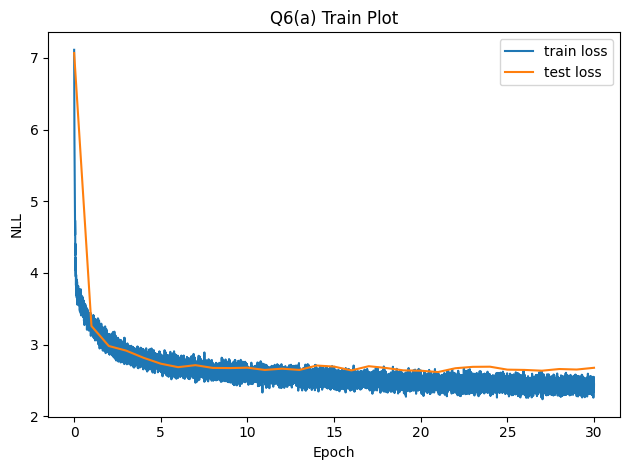

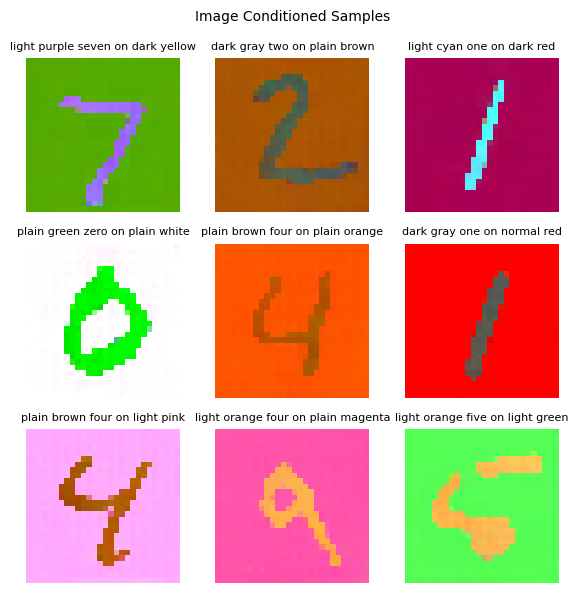

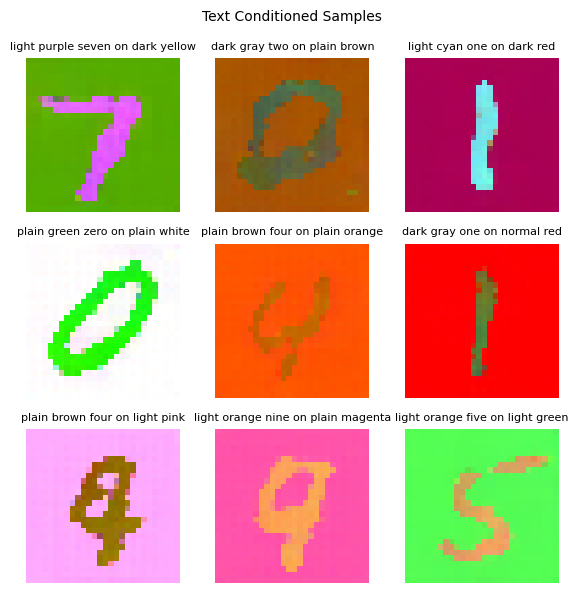

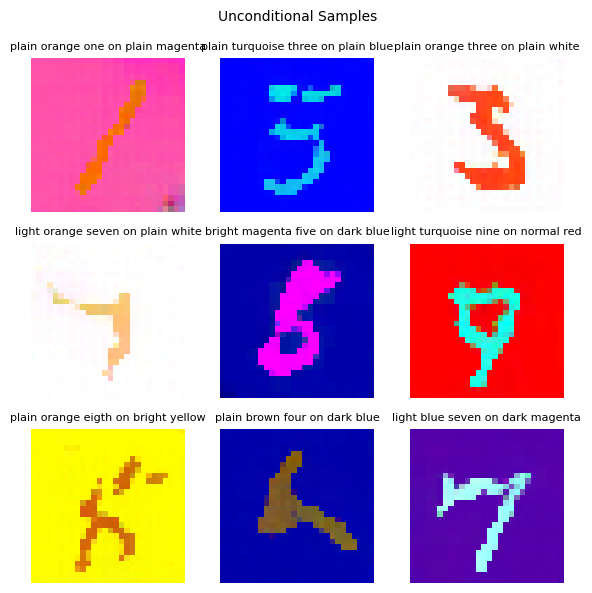

In [ ]:
Training